# A/B-тест нового алгоритма рекомендаций в развлекательном приложении: рост вовлечённости пользователей

**Цель исследования** — оценить влияние нового алгоритма рекомендаций на вовлечённость пользователей развлекательного приложения с «бесконечной» лентой. В приложении есть две модели монетизации: платная подписка без рекламы и показ рекламы для неподписанных пользователей.

Для проверки гипотезы о том, что новый алгоритм повышает интерес к контенту, был проведён A/B-тест с ключевой метрикой доли успешных сессий — случаев, когда пользователь просмотрел четыре и более страниц за одну сессию. Результаты эксперимента позволили оценить эффективность нововведения и принять решение о его внедрении.

**Работа над A/B-тестом проводилась в три этапа:**

**1. Анализ исторических данных (EDA)**   
На первом этапе проводился исследовательский анализ данных, чтобы определить основные метрики, отражающие вовлечённость пользователей, и выбрать наиболее информативную для A/B-теста. Также на этом этапе оценивался базовый уровень выбранной метрики, что позволило рассчитать минимально детектируемый эффект, а также определить необходимую длительность эксперимента и размеры выборки с учётом текущего трафика.


**2. Проверка корректности проведения эксперимента**  
После первых дней эксперимента проверялась правильность его организации: равномерность распределения пользователей по группам и соответствие ключевых характеристик (устройства, регионы). Это позволяло убедиться, что экспериментальные группы сопоставимы и результаты будут достоверными.


**3. Анализ результатов и проверка гипотезы**  
На финальном этапе проводилась проверка гипотезы с помощью статистических тестов, оценивался эффект нового алгоритма рекомендаций, делались выводы о целесообразности внедрения нововведения.

## Описание данных

Будет собираться следующая информация об участниках эксперимента, эта же информация содержится в исторических данных:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе проводилась работа с историческими данными приложения.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as st
from math import ceil

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загрузим исторические данные
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Изучим первые пять строк полученного датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
Для знакомства с историческими данными рассмотрим информацию о пользователе с наибольшим количеством сессий. Это позволит изучить структуру таблицы и понять логику формирования каждого столбца данных.

In [4]:
# Находим user_id с наибольшим числом сессий
active_user = sessions_history['user_id'].value_counts().idxmax()

# Выводим все сессии этого пользователя
sessions_history[sessions_history['user_id'] == active_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Для визуализации динамики регистраций и общего роста аудитории приложения будут построены линейные диаграммы.

- Визуализация общего числа пользователей и общего числа зарегистрированных пользователей по дням

In [5]:
# Рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения
date_users = sessions_history.groupby('session_date').agg(
    unique_users = ('user_id', 'nunique'),
    registered_users = ('registration_flag', 'sum')
).reset_index()

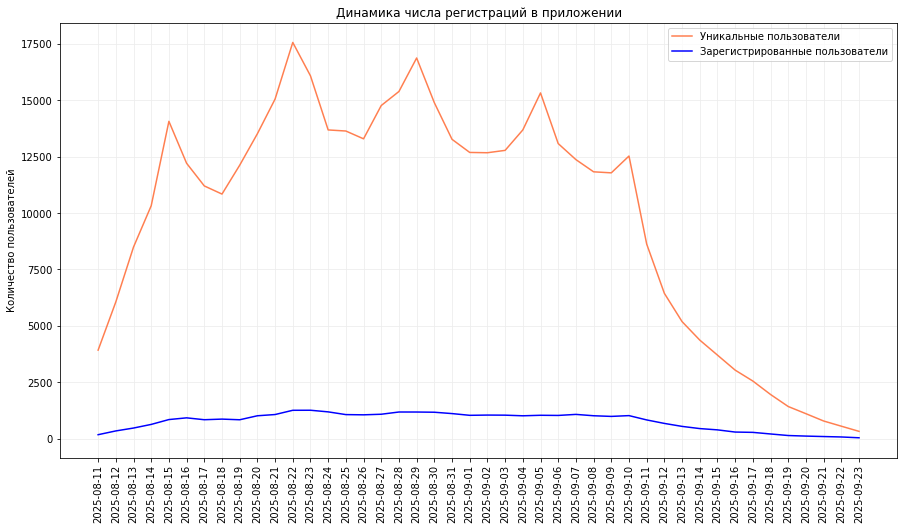

In [6]:
# Создадим переменные для будущего графика
x = date_users['session_date']
y_a = date_users['unique_users']
y_b = date_users['registered_users']

# Построим график общего числа пользователей и общего числа зарегистрированных пользователей по дням
plt.figure(figsize = (15, 8))
plt.plot(x, y_a, label = 'unique_users', color = 'coral')
plt.plot(x, y_b, label = 'registered_users', color = 'blue')

plt.ylabel('Количество пользователей')
plt.legend(['Уникальные пользователи', 'Зарегистрированные пользователи'])
plt.title('Динамика числа регистраций в приложении')
plt.xticks(rotation = 90)
plt.grid(color = '#ededed')
plt.show()

- Визуализация изменения доли зарегистрированных пользователей от всех пользователей по дням

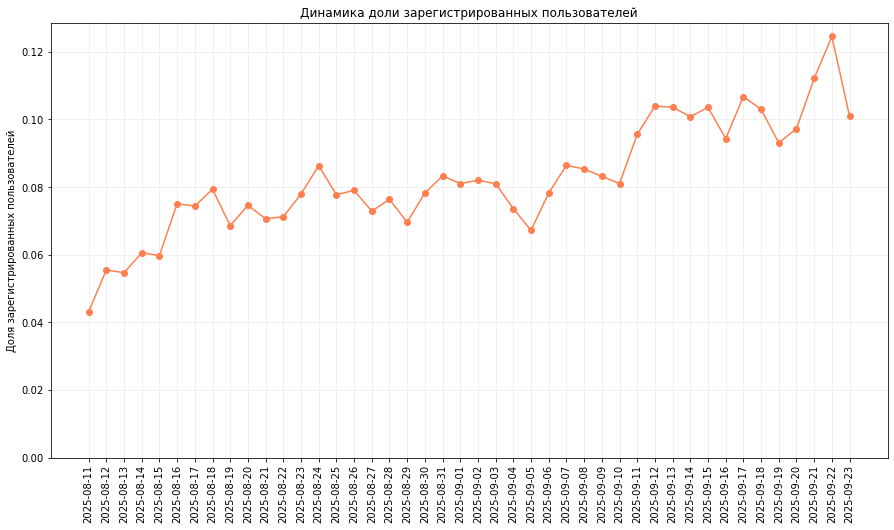

In [7]:
# Доля зарегистрированных пользователей от всех пользователей по дням
date_users['registered_share'] = date_users['registered_users']/date_users['unique_users']

# Создадим переменные для будущего графика
x = date_users['session_date']
y = date_users['registered_share']

# Построим график доли зарегистрированных пользователей от всех пользователей по дням
plt.figure(figsize = (15, 8))
plt.plot(x, y, color = 'coral', marker = 'o')

plt.ylabel('Доля зарегистрированных пользователей')
plt.title('Динамика доли зарегистрированных пользователей')
plt.xticks(rotation = 90)
plt.grid(color = '#ededed')
plt.ylim(bottom = 0)

plt.show()

**По диаграммам можно выделить следующие тенденции:**
1. Динамика уникальных и зарегистрированных пользователей

- С 11.08 по 22.08 наблюдается рост числа как уникальных пользователей, так и зарегистрированных.

- Период с 22.08 по 10.09 характеризуется относительной стабильностью обеих метрик.

- После 10.09 происходит резкое снижение числа пользователей, особенно уникальных, вплоть до конца периода наблюдений (23.09).

2. Доля зарегистрированных пользователей

- На протяжении всего периода с 11.08 по 23.09 доля зарегистрированных пользователей среди всех пользователей демонстрирует общий рост.

- Даже при падении абсолютного числа пользователей после 10.09 доля зарегистрированных продолжала расти, что может указывать на повышенную конверсию среди оставшейся аудитории.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

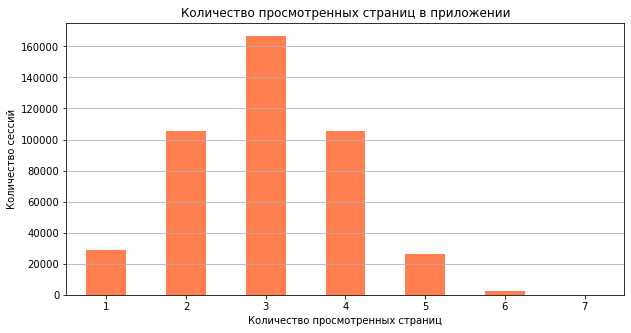

In [8]:
# Определим кол-во сессий с разным числом просмотренных страниц
sessions_page = sessions_history['page_counter'].value_counts().sort_index()

# Построим столбчатую диаграмму для демонстрации
plt.figure(figsize = (10, 5))

sessions_page.plot.bar(color = 'coral')

plt.title('Количество просмотренных страниц в приложении')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xticks(rotation = 0)
plt.grid(axis = 'y')

plt.show()

В большинстве сессий пользователи просматривают 3 страницы (ок. 170 тыс. сессий). Примерно одинаковое количество сессий приходится на 2 и 4 страницы (около 105 тыс.). Одностраничные сессии встречаются заметно реже (ок. 30 тыс.), что говорит о том, что значительная часть аудитории всё же просматривает больше одного экрана. Сессий с 5 страницами примерно столько же, с 6 страницами — почти исчезающе мало (2,5 тыс.), а с 7 страницами — крайне редко (всего 92).

Таким образом, большинство пользователей просматривают от 2 до 4 страниц за сессию, а более продолжительные сессии встречаются редко. Это может указывать на то, что контент удерживает внимание лишь на несколько экранов, а лишь небольшой процент аудитории остаётся вовлечённым на длительное время.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной метрикой для продукта.

Для анализа изменения доли успешных сессий от всех сессий в течение исследуемого периода имеет смысл построить линейную диаграмму.

In [9]:
# Создадим столбец, в котором обозначим сессии с большим числом просмотренных страниц (>= 4)
sessions_history['good_session'] = 0
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1

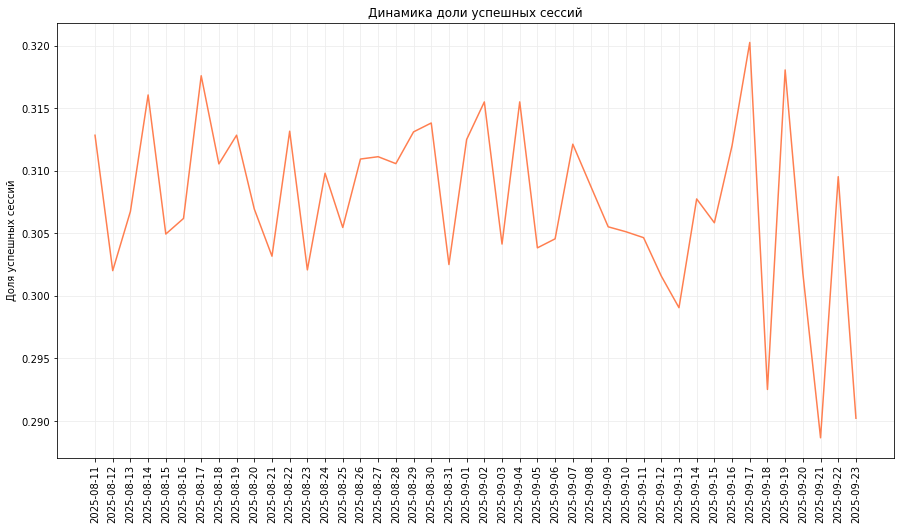

In [10]:
# Определим долю успешных сессий по дням
good_sessions_by_day = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Создадим переменные для будущего графика
x = good_sessions_by_day['session_date']
y = good_sessions_by_day['good_session']

# Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения
plt.figure(figsize = (15, 8))
plt.plot(x, y, color = 'coral')

plt.ylabel('Доля успешных сессий')
plt.title('Динамика доли успешных сессий')
plt.xticks(rotation = 90)
plt.grid(color = '#ededed')

plt.show()

Доля успешных сессий в течение всего периода остаётся относительно стабильной, колеблясь в диапазоне от 0,29 до 0,32. Небольшие колебания от дня к дню носят нерегулярный характер и не формируют выраженного тренда на рост или снижение.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Сформулировать нулевую и альтернативную гипотезы

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя, что, предположительно, должно повысить их вовлечённость. В рамках эксперимента целевая метрика — **доля успешных сессий**, то есть доля сессий, в которых пользователь просмотрел 4 и более страниц. Этот показатель используется как основной индикатор уровня вовлечённости.

**Нулевая гипотеза:** доли успешных сессий равны в группах A и B.

**Альтернативная гипотеза:** доля успешных сессий в группе B больше, чем в группе A.

#### 2.2. Расчёт размера выборки
Рассчитаем необходимое для эксперимента количество пользователей.

In [11]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Рассчитаем длительность A/B-теста, используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения.

In [12]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size)*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {round(avg_daily_users)} пользователей в день составит {test_duration} дней.")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней.


Рассчитали допустимый минимальный срок для проведения A/B-теста — 9 дней. однако для повышения надёжности результатов теста желательно провести его дольше — например, на 14 дней, чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

После запуска A/B-теста важно убедиться в корректности его проведения, в частности, в правильности распределения пользователей между группами. Для этого проверяются:

- **Сопоставимое количество пользователей** в тестовой и контрольной группах.

- **Независимость пользователей** — отсутствие участников, одновременно присутствующих в обеих группах.

- **Равномерность распределения по ключевым характеристикам**, в нашем случае — по используемым устройствам и регионам.

Для начала определим и визуализируем количество уникальных пользователей в каждой группе по итогам первого дня наблюдения.

In [13]:
# Сохраним в переменную данные с информацией о сессиях пользователей в первый день теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [14]:
# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп
group_users = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()

# Рассчитаем процентную разницу в количестве пользователей в группах A и B
a_users_count = group_users[group_users['test_group'] == 'A']['user_id'].iloc[0]
b_users_count = group_users[group_users['test_group'] == 'B']['user_id'].iloc[0]
perc_diff = 100 * abs(a_users_count - b_users_count)/a_users_count

print(f'Процентная разница в количестве пользователей в группах A и B составляет {perc_diff.round(2)}%')

Процентная разница в количестве пользователей в группах A и B составляет 0.74%


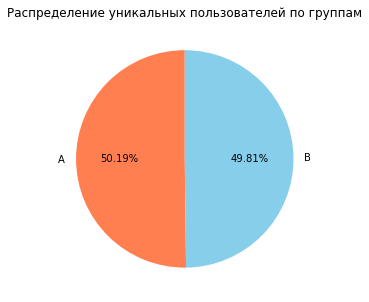

In [15]:
# Построим круговую диаграмму для демонстрации распределения пользователей по группам
plt.figure(figsize = (5, 5))

plt.pie(group_users['user_id'],
        labels = group_users['test_group'],
        colors = ['coral', 'skyblue'],
        startangle = 90,
        autopct = '%1.2f%%')

plt.title('Распределение уникальных пользователей по группам')
plt.show()

Пользователи распределены между группами равномерно: 50,19% — в группе A и 49,81% — в группе B.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [16]:
# Считаем кол-во уникальных значений test_group для каждого пользователя 
# Отбираем только тех пользователей, у которых количество уникальных значений test_group больше 1.
intersection = sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')

print(f'Пользователей, которые встречаются одновременно в группах A и B: {len(intersection)}.')

Пользователей, которые встречаются одновременно в группах A и B: 0.


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

In [17]:
# Создадим сводную таблицу с информацией о распределении типов устройств для пользователей из разных групп
device_groups = pd.pivot_table(sessions_test_part, 
                               index = 'device', 
                               columns = 'test_group', 
                               values = 'user_id', 
                               aggfunc = 'nunique')
device_groups

test_group,A,B
device,,
Android,656,668
Mac,156,148
PC,369,381
iPhone,296,269


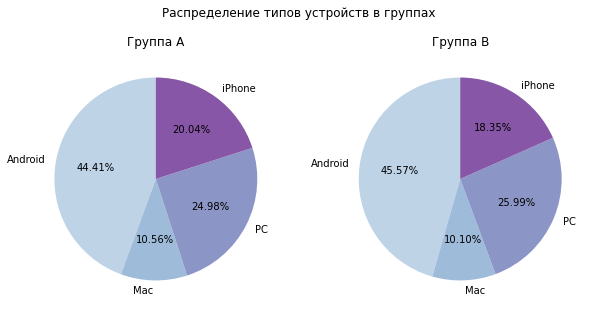

In [18]:
# Построим диаграмму с информацией о распределении типов устройств в группах A и B
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].pie(device_groups['A'],
            labels = device_groups.index,
            colors = ['#BFD3E6', '#9EBCDA', '#8C96C6', '#8856A7'],
            startangle = 90,
            autopct = '%1.2f%%')
axes[0].set_title('Группа A')

axes[1].pie(device_groups['B'],
            labels = device_groups.index,
            colors = ['#BFD3E6', '#9EBCDA', '#8C96C6', '#8856A7'],
            startangle = 90,
            autopct = '%1.2f%%')
axes[1].set_title('Группа B')

plt.suptitle('Распределение типов устройств в группах')
plt.show()

Пользователи равномерно распределены по устройствам, что важно для корректности A/B-теста. Это исключает риск, что различия в целевой метрике будут вызваны не самим тестом, а, например, особенностями поведения владельцев Android и iOS (разная конверсия, активность или средний чек).

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

In [19]:
# Создадим сводную таблицу с информацией о распределении по регионам для пользователей из разных групп
region_groups = pd.pivot_table(sessions_test_part,
                               index = 'region',
                               columns = 'test_group',
                               values = 'user_id',
                               aggfunc = 'nunique')

# Выведем значения в долях
region_shares = region_groups/region_groups.sum()
region_shares

test_group,A,B
region,,
CIS,0.436019,0.439973
EU,0.151659,0.148022
MENA,0.412322,0.412005


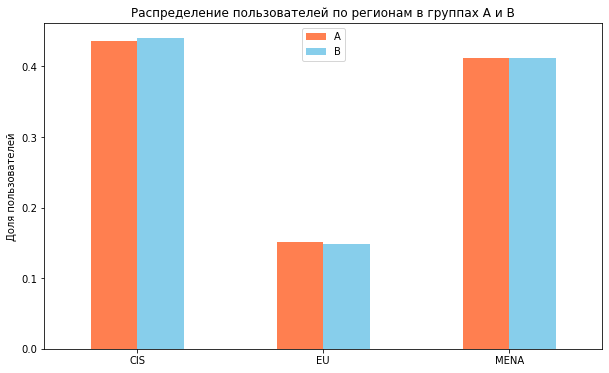

In [20]:
# Построим диаграмму для демонстрации распределения пользователей по регионам в группах A и B
region_shares.plot(kind = 'bar', 
                   rot = 0,
                   color = ['coral', 'skyblue'],
                   figsize = (10, 6))

plt.xlabel('')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей по регионам в группах A и B')
plt.legend()
plt.show()

Распределение пользователей по регионам также равномерное.

#### 3.5. Вывод после проверки A/B-теста

После первого дня проведения A/B-теста был выполнен мониторинг для проверки корректности его проведения. По результатам анализа можно сделать следующие выводы:

1. Обнаружены незначительные различия в количестве пользователей в двух группах: процентное отклонение между группами A и B составляет 0,74%, что находится в пределах статистической погрешности и не является значимым.

2. Выборки пользователей в тестовой и контрольной группах являются независимыми: не выявлено ни одного пользователя, который одновременно присутствовал бы в обеих группах.

3. Сохраняется равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам, что подтверждает отсутствие систематических смещений.

Таким образом, на данном этапе можно заключить, что A/B-тест проводится корректно, без выявленных нарушений.

### 4. Проверка результатов A/B-теста

После завершения A/B-теста необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [21]:
# Сохраним в переменную данные с результатами A/B-теста
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [22]:
# Создадим столбец, в котором обозначим сессии с большим числом просмотренных страниц (>= 4)
sessions_test['good_session'] = 0
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Для этого используем t-тест, который позволит сделать вывод о равенстве средних двух выборок.

In [23]:
# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп
daily_sessions = pd.pivot_table(sessions_test,
                 index = 'session_date',
                 columns = 'test_group',
                 values = 'session_id',
                 aggfunc = 'nunique')
daily_sessions

test_group,A,B
session_date,,
2025-10-14,1502,1628
2025-10-15,2235,2283
2025-10-16,3280,3241
2025-10-17,4089,4054
2025-10-18,5013,5059
2025-10-19,6535,6779
2025-10-20,5837,6089
2025-10-21,3927,3981
2025-10-22,3083,3111


In [24]:
# Проведем t-тест для проверки того, насколько значимы различия в количестве уникальных дневных сессий в двух выборках 
# Нулевая гипотеза: Среднее кол-во уникальных дневных сессий одинаково в двух выборках.
# Альтернативная гипотеза: Среднее кол-во уникальных дневных сессий отличается в двух выборках.

a = daily_sessions['A']
b = daily_sessions['B']

alpha = 0.05

results = st.ttest_ind(a, b, alternative = 'two-sided')

if results.pvalue < alpha:
    print(f'p-value = {results.pvalue.round(2)}')
    print('Среднее кол-во уникальных дневных сессий отличается в двух выборках.')
else:
    print(f'p-value = {results.pvalue.round(2)}')
    print('Среднее кол-во уникальных дневных сессий одинаково в двух выборках. Тест проведен корректно.')

p-value = 0.94
Среднее кол-во уникальных дневных сессий одинаково в двух выборках. Тест проведен корректно.


#### 4.3. Сравнение доли успешных сессий

Когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

In [25]:
# Рассчитаем долю успешных сессий в выборках A и B
share_good_session = sessions_test.groupby('test_group')['good_session'].mean()
diff_good_session = abs(share_good_session['A'] - share_good_session['B'])

print(f'Доля успешных сессий в выборках A и B: {share_good_session}')
print()
print(f'Разница между выборками A и B: {(diff_good_session*100).round(2)}%')

Доля успешных сессий в выборках A и B: test_group
A    0.307723
B    0.318290
Name: good_session, dtype: float64

Разница между выборками A и B: 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения необходимо ответить на вопрос: является ли это изменение статистически значимым.

Используя z-тест пропорций, проверим, является ли изменение в метрике доли успешных сессий статистически значимым.

In [26]:
# Проведем z-тест пропорций для проверки того, насколько значимы различия в доле успешных сессий в группах A и B
# H0: доли успешных сессий равны в группах A и B
# H1: доля успешных сессий в группе B выше, чем в группе A

n_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique() # размер выборки A
n_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique() # размер выборки B
m_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum() # кол-во успешных сессий в группе A
m_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum() # кол-во успешных сессий в группе B

alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest([m_b, m_a],
                                              [n_b, n_a],
                                              alternative = 'larger')

if p_value_ztest > alpha:
    print(f'p-value = {p_value_ztest}')
    print('Доли успешных сессий в контрольной и тестовой группах равны.')
else:
    print(f'p-value = {p_value_ztest}')
    print('Доля успешных сессий в тестовой группе выше, чем в контрольной.')

p-value = 0.0001574739988036123
Доля успешных сессий в тестовой группе выше, чем в контрольной.


Разница в 1,06% в пользу тестовой группы статистически значима (p-value ≈ 0,00016), что подтверждает улучшение метрики.

#### 4.5. Общая информация о проведенном эксперименте

In [26]:
# Посчитаем количество задействованных в эксперименте пользователей
users_count = sessions_test['user_id'].nunique()

# Определим длительность эксперимента
duration_test = sessions_test['session_date'].nunique()

# Определим даты проведения эксперимента
first_day = sessions_test['session_date'].min()
last_day = sessions_test['session_date'].max()

print(f'В эксперименте было задействовано {users_count} пользователей.')
print(f'Эксперимент длился {duration_test} дней: с {first_day} по {last_day}.')

В эксперименте было задействовано 30579 пользователей.
Эксперимент длился 20 дней: с 2025-10-14 по 2025-11-02.


Был проведён A/B-тест, чтобы оценить, как новый алгоритм рекомендаций влияет на вовлечённость пользователей. Ключевой метрикой была доля успешных сессий — случаев, когда пользователь просмотрел 4 и более страниц за одну сессию. Была выдвинута гипотеза о том, что при внедрении нового алгоритма рекомендаций доля успешных сессий увеличится.

**Характеристики выборки**  
В тесте участвовало **30 579 пользователей**, распределённых по устройствам и регионам равномерно: 
- 45% — Android, 20% — iPhone, 25% — PC, 10% — Mac; 
- по регионам: 44% — CIS, 15% — EU, 41% — MENA. 

**Сроки проведения эксперимента**  
Эксперимент длился **20 дней** — с 14.10.2025 по 02.11.2025.

**Результаты**  
По результатам A/B-теста доля успешных сессий выросла с 30.77% в группе A до 31.83% в группе B, что составляет +1.06 процентных пункта или **+3.45%** в относительном выражении. Минимальный детектируемый эффект (MDE) был задан как 3% относительного изменения, а полученный эффект этот порог превысил. Статистический анализ показал, что различия значимы — **p-value = 0.00016**, что меньше уровня значимости 0.05.

Таким образом, **нововведение стоит внедрять** в приложение, так как оно дало измеримый и статистически подтверждённый положительный результат.